<a href="https://colab.research.google.com/github/ghkdwnwsdud/AI-Project/blob/main/CNN_version2024_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Intelligence Project with code, MLP vs CNN (dataset: CIFAR-10), 2023.09.14, Juann Kim #


## Today's Agenda ##

1. What is the Convolutional Neural Networks(CNNs) ?
2. Does Multi Layer Perceptrons(MLPs) learn image data well ?
3. Why do we need Convolutional Neural Networks(CNNs) ?
4. Assignments



## Convolutional Neural Networks ##
##### 1. Regular Neural Nets don’t scale well to full images. ###
##### 2. Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth. #####

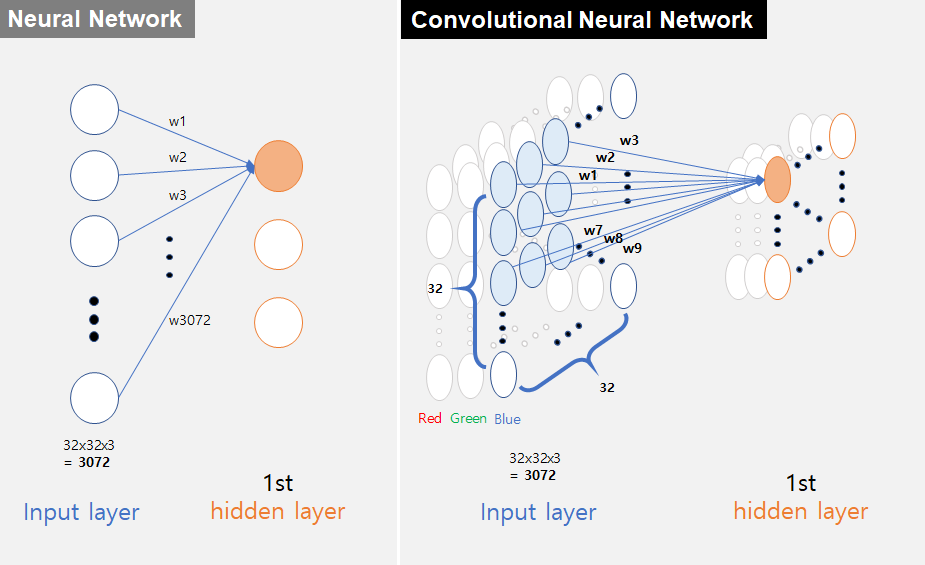


## The CIFAR-10 dataset ##
* The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset.
* They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.
* The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
* There are 50000 training images and 10000 test images. <br>
<span style='color:blue'>CIFAR-10 : https://www.cs.toronto.edu/~kriz/cifar.html</span>

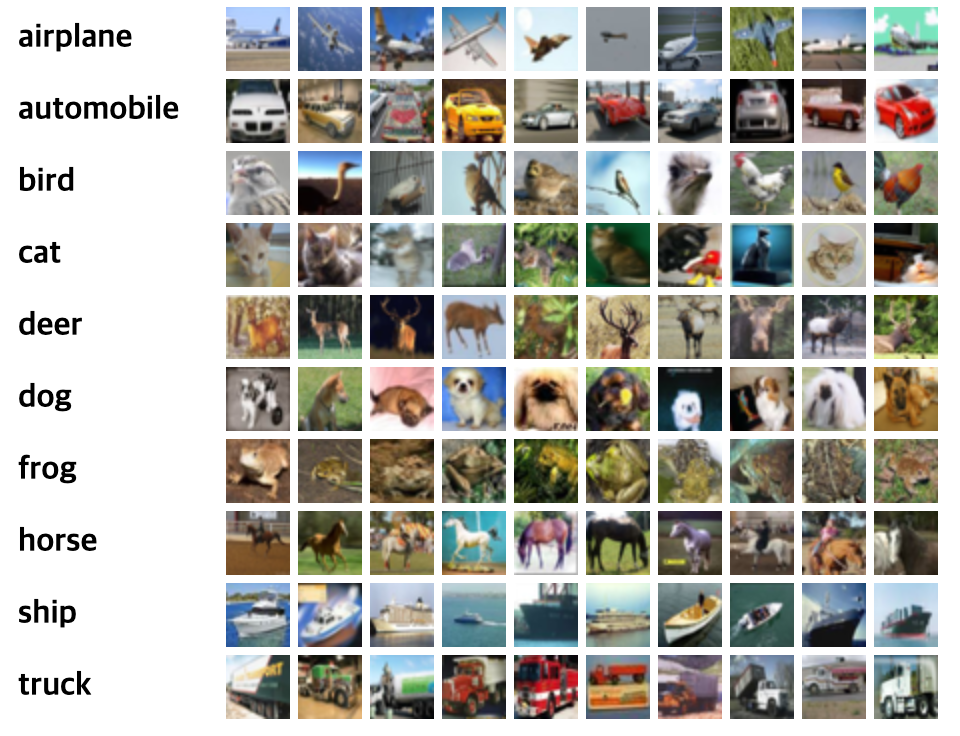

In [1]:
# import lib.
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, datasets

In [2]:
# Check our device #
# If you use a CPU, you might get a result slowly
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)

Using PyTorch version:  2.2.1+cu121 Device:  cuda


In [3]:
# Set a batch size and epoch before training.
batch_size = 64

# Load train and test dataset from CIFAR-10
train_dataset = datasets.CIFAR10(root='../data/CIFAR10',
                                 train=True, download=True, transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root="../data/CIFAR10", train=False, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:07<00:00, 24267653.47it/s]


Extracting ../data/CIFAR10/cifar-10-python.tar.gz to ../data/CIFAR10


In [4]:
# DataLoader를 이용해서 data를 한번 가공해서 가져오게 되면 시간이 줄어들고 더 편하게 이용할 수 있게됨
# the train dataset will be split by batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Show first mini batch from train data
for (X_train, y_train) in train_loader:
    # check the size of one mini batch is same as batch size #
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break


'''
[ Result ]
We can see the sizes of each sample
channel: 3(R, G, B) /// image size: 32x32
'''

#batch_size가 64이므로 64개의 사진을 들고옴, 3 - R, G, B를 설명함, 32x32 이미지의 가로 세로 사이즈를 나타냄

X_train:  torch.Size([64, 3, 32, 32]) type:  torch.FloatTensor
y_train:  torch.Size([64]) type:  torch.LongTensor


'\n[ Result ]\nWe can see the sizes of each sample\nchannel: 3(R, G, B) /// image size: 32x32\n'

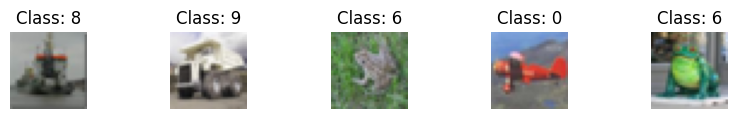

In [5]:
# Check few samples
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))


'''
The Class is a neumerical value
Each value implies the index of the CIFAR-10 as we can see in the above CIFAR-10 image.
'''

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [6]:
class Net(nn.Module):     #MLP의 형태를 이용함

  def __init__(self):
    super(Net, self).__init__()

    # (width * height * channel) = 32*32*3
    self.fc1 = nn.Linear(32*32*3, 512)        #512개의 hidden layer
    self.fc2 = nn.Linear(512, 256)            #256개의 hidden layer
    self.fc3 = nn.Linear(256, 10)


  def forward(self, x):
    # reduce a dimension
    # each image has a 32x32 size, We need to flatten each image #
    x = x.view(-1, 32 * 32 * 3)               #view를 통해 형태변환을 간단하게 해줄 수 있음, 일렬로 펴고 싶은 데이터 사이즈를 적음 (32 * 32 * 3) -> 모든 데이터가 한줄로 펴짐

    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)

    x = self.fc3(x)


    x = F.log_softmax(x, dim=1)

    return x

# The architecture and process of the Model #
### Input layer: (32x32x3) => Hidden layer 1: (512) => Hidden layer 2: (256) => Output layer: (10) ###
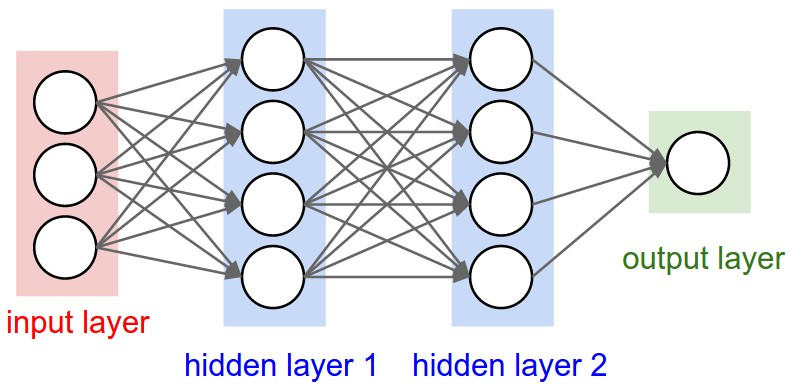

In [7]:
# Assign to a defined device
model = Net().to(DEVICE)

# Set an optimizer as Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# See our model
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
# Training Function
def train(epoch, model, train_loader, optimizer, log_interval):

    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        # Assign to a defined device
        image = image.to(DEVICE)
        label = label.to(DEVICE)

        # Initialize a gradient
        optimizer.zero_grad()

        # Get a prediction of model
        output = model(image)

        # Get a loss value
        loss = criterion(output, label)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Print logs
        if batch_idx % log_interval == 0:
            print("Train Epoch {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(epoch, batch_idx*len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [9]:
# Function of Model's Evaluation
def evaluate(model, test_loader):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad(): # Stop updating a gradient during testing


        for image, label in test_loader:
            # Assign to a defined device
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)
            test_loss += criterion(output, label).item()

            # Predict with the label with the largest value out of 10 results
            prediction = output.max(1, keepdim=True)[1]

            # Cumulate the number of correct answers
            correct += prediction.eq(label.view_as(prediction)).sum().item()



    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

In [10]:
epochs = 10

for epoch in range(1, epochs+1):
    train(epoch, model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print("\n[Epoch: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(epoch, test_loss, test_accuracy))

Train Epoch 1 [0/50000(0%)]	Train Loss: 2.308699
Train Epoch 1 [12800/50000(26%)]	Train Loss: 1.806623
Train Epoch 1 [25600/50000(51%)]	Train Loss: 1.760669
Train Epoch 1 [38400/50000(77%)]	Train Loss: 1.685568

[Epoch: 1], 	Test Loss: 0.0270, 	Test Accuracy: 38.10 % 

Train Epoch 2 [0/50000(0%)]	Train Loss: 1.496868
Train Epoch 2 [12800/50000(26%)]	Train Loss: 1.856089
Train Epoch 2 [25600/50000(51%)]	Train Loss: 1.788837
Train Epoch 2 [38400/50000(77%)]	Train Loss: 1.756320

[Epoch: 2], 	Test Loss: 0.0249, 	Test Accuracy: 43.24 % 

Train Epoch 3 [0/50000(0%)]	Train Loss: 1.656327
Train Epoch 3 [12800/50000(26%)]	Train Loss: 1.664445
Train Epoch 3 [25600/50000(51%)]	Train Loss: 1.531257
Train Epoch 3 [38400/50000(77%)]	Train Loss: 1.822890

[Epoch: 3], 	Test Loss: 0.0244, 	Test Accuracy: 44.07 % 

Train Epoch 4 [0/50000(0%)]	Train Loss: 1.639662
Train Epoch 4 [12800/50000(26%)]	Train Loss: 1.530777
Train Epoch 4 [25600/50000(51%)]	Train Loss: 1.573999
Train Epoch 4 [38400/50000(77%)]	

### MLPs can not learn image data well.  ###
* We need to use other method. (=CNN)
* Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.


## Convolutional Neural Networks ##
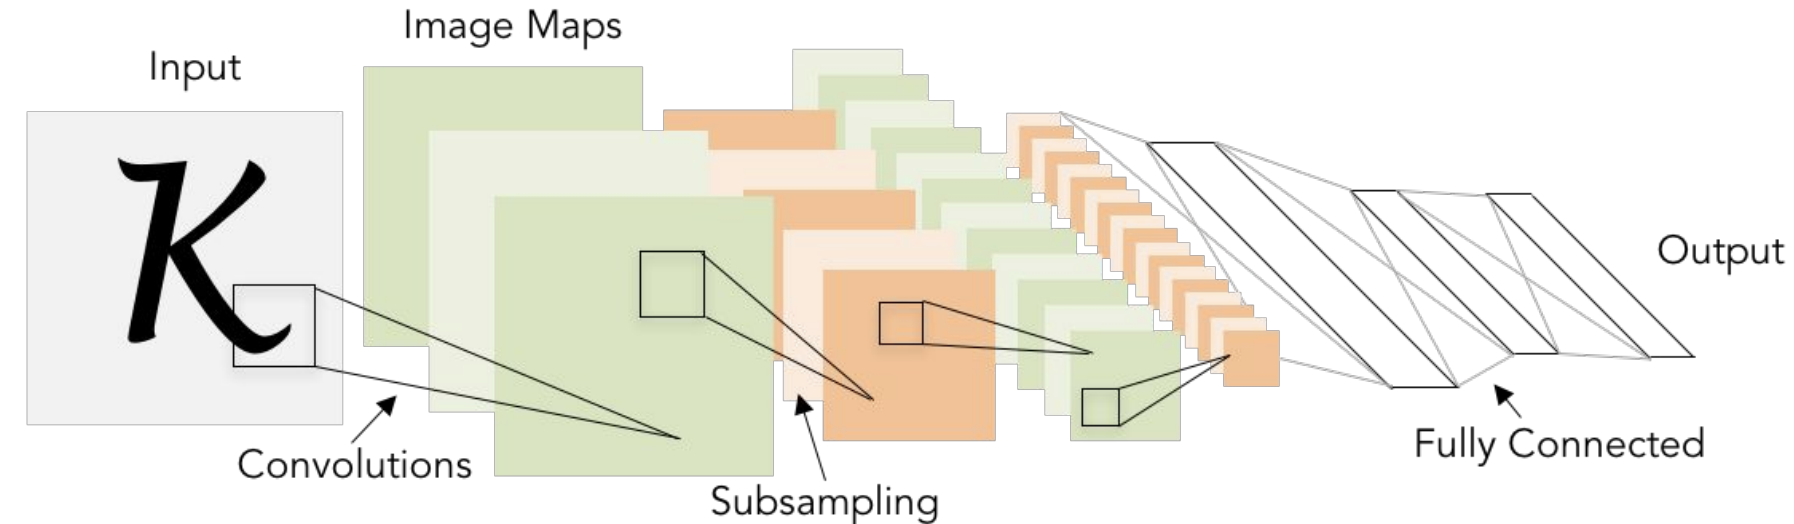

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # in_channel: R, G, B
        # kernel_size: 3x3
        # padding: the number of zero padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=3, padding=1, stride=1)         #convolution layer를 거칠 때마다 2차원 필터를 통해서 중요한 정보가 압축되어서 전달됨
        self.conv2 = nn.Conv2d(in_channels=9, out_channels=18, kernel_size=3, padding=1)

        # kernel_size= 2x2, maximum value will be replaced as a representative value of 4 pixels.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                                                 #poolng : 단순하게 지역적인 정보를 가져오기만 하면 정보가 우리가 원하는데로 반영되지 않을 수 도 있기 때문에 pooling을 해줌

        # Fully Connected Layers
        self.fc1 = nn.Linear(8*8*18, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # print(x.shape)
        x = self.pool(x)



        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)                  #convolution -> activation func -> pooling : pooling을 통해서 우리가 얻게 된 데이터의 중요한 성질이 극대화 됨

        x = x.view(-1, 8*8*18)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = F.log_softmax(x)

        return x


In [12]:
# Load our model
model = CNN().to(DEVICE)

# For training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# Show a model's architecture
print(model)

CNN(
  (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)


In [13]:
# Training
epochs = 10

for epoch in range(1, epochs+1):
  train(epoch, model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy = evaluate(model, test_loader)

  print("\n[Epoch: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(epoch, test_loss, test_accuracy))

<ipython-input-11-8bcdbafefde2>:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch 1 [0/50000(0%)]	Train Loss: 2.303602
Train Epoch 1 [12800/50000(26%)]	Train Loss: 2.015591
Train Epoch 1 [25600/50000(51%)]	Train Loss: 1.811096
Train Epoch 1 [38400/50000(77%)]	Train Loss: 1.614958

[Epoch: 1], 	Test Loss: 0.0240, 	Test Accuracy: 43.59 % 

Train Epoch 2 [0/50000(0%)]	Train Loss: 1.383554
Train Epoch 2 [12800/50000(26%)]	Train Loss: 1.603989
Train Epoch 2 [25600/50000(51%)]	Train Loss: 1.360979
Train Epoch 2 [38400/50000(77%)]	Train Loss: 1.394843

[Epoch: 2], 	Test Loss: 0.0231, 	Test Accuracy: 45.68 % 

Train Epoch 3 [0/50000(0%)]	Train Loss: 1.491834
Train Epoch 3 [12800/50000(26%)]	Train Loss: 1.217093
Train Epoch 3 [25600/50000(51%)]	Train Loss: 1.080702
Train Epoch 3 [38400/50000(77%)]	Train Loss: 1.125061

[Epoch: 3], 	Test Loss: 0.0194, 	Test Accuracy: 56.02 % 

Train Epoch 4 [0/50000(0%)]	Train Loss: 1.012120
Train Epoch 4 [12800/50000(26%)]	Train Loss: 1.276119
Train Epoch 4 [25600/50000(51%)]	Train Loss: 0.977853
Train Epoch 4 [38400/50000(77%)]	

In [ ]:
#stride가 1이라면 filter를 한칸씩, 2라면 두칸씩 옮겨다니는 방식
#padding: 가장자리를 적절하게 처리해주기 위해서 (padding이 없으면 가장자리가 공평하게 처리되지 않는 경우가 있음), padding이 1이라면 1칸씩, 2라면 2칸씩 정보가 없는 요소를 배치하는 방식
#32x32사이즈의 사진에 padding을 2로 적용해주게 되면 양쪽에 2씩 padding이 생겨 36x36의 사이즈가 됨


### The ouput of each Conv layer ###


(H, W): shape of input image
|| (FH, FW): shape of filter
|| (OH, HW): shape of output
|| P: padding size
|| S: stride size


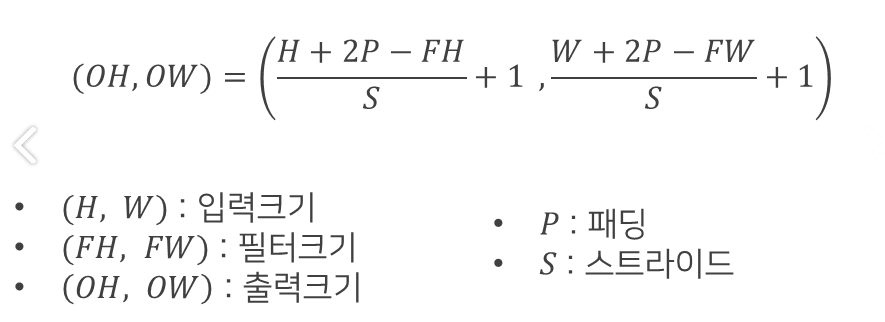

# Assignments #
1. 더 복잡한(깊은) Convolution Layers를 쌓아서 제시된 CNN보다 높은 성능 달성하기 [1점]<br>
    * 제시된 CNN의 마지막 epoch_8 ~ epoch_10까지의 결과를 캡쳐한다.
    * 새롭게 만든 CNN의 마지막 epoch_8 ~ epoch_10까지의 결과를 캡쳐한다. (바뀐 점을 1~2줄 이내로 기술해주세요.)
    * 성능 비교를 위해 위 두 가지 결과의 캡쳐본을 첨부해 주세요. (각 캡쳐본이 어떤 것의 결과인지 간단하게 기재해주세요.)
<br><br>
2. 아래 제시된 Q2 문제 풀기 [1점]
* Input Image size: (32 x 32)
* Filter size = (5 x 5)
* Stride = 1, Pading = 2
* What is the output image size ?
     * 정답을 "(output_height, output_width)" 로 기재해 주세요.
<br><br>
3. CNN에서 Pooling의 의미or역할 와 장점 한 가지를 서술해 주세요. [1점]
    * 자유롭게 역할과 장점을 기재하세요. (최대 4문장)

[ANSWER]

2. (((32+4-5)/1)+1, ((32+4-5)/1)+1)
   (32, 32)

3. Pooling 의 역할과 장점 : 공간 차원 축소, 위치 불변성 보장, 계산량 감소, 과적합 방지, 불변성 특성 강화, 최적화 기능 -> 입력 데이터의 공간 차원을 축소하고 중요한 정보를 강조하여 모델의 성능을 향상시키는 데에 기여합니다.

# Artificial Intelligence Project with code, VGG16 Transfer Learning, 2023.09.14, Juann Kim

If you are using Google Colaborator, first activate the runtime.
Then, drag three files
*   banana.jpg
*   cat.jpg
*   imagenet_class_index.json
and other image files into the file tab.

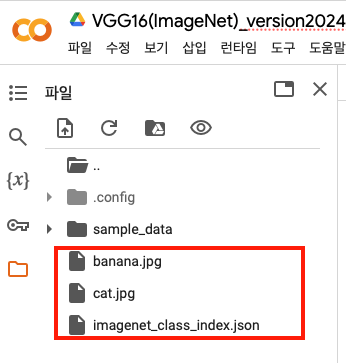


In [14]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [15]:
# check the PyTorch version
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.2.1+cu121
Torchvision Version:  0.17.1+cu121


In [16]:
# load the pre trained VGG16 model.

use_pretrained = True  # Do you want to use a pre trained model? == Frozen weights.
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # evaluation mode

# print the architecture
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
class BaseTransform():                    #각각의 모델마다 data를 학습시킨 특성이 다르기 때문에 표준화해주는 과정
    """

    Attributes
    ----------
    mean : (R, G, B)
        means of each color channel
    std : (R, G, B)
        means of each color standard deviation
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  #
            transforms.CenterCrop(resize),  # center of image will be cropped by (resize × resize)
            transforms.ToTensor(),
            transforms.Normalize(mean, std)  # standardization
        ])

    def __call__(self, img):
        return self.base_transform(img)

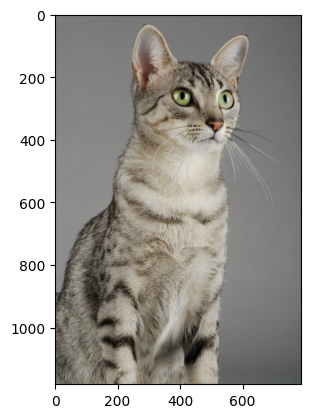

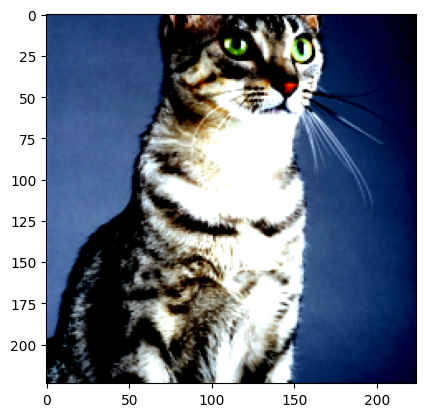

In [19]:
# load an image have to modify
image_file_path = 'cat.jpg'
img = Image.open(image_file_path)  # W x H x C

# visualize the image
plt.imshow(img)
plt.show()

# pre processing, crop & std
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# convert (C, H, W) to (H, W, C),
img_transformed = img_transformed.numpy().transpose((1, 2, 0))

# The "imshow" function needs a range of 0-1 (scaling)
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

#변환을 시켜서 고양이 사진과 바나나 사진을 비교할 수 있도록 해줌 (가로세로 비율이나 크기를 똑같이 맞춰줌, 색상을 좀 더 특징적인 형태로 바꿔줌) -> 사진이 훨씬 범용적이고 사용하기 좋은 특징적인 형태로 변환됨

In [20]:
# ILSVRC (labels information)
ILSVRC_class_index = json.load(open('imagenet_class_index.json', 'r'))    #딥러닝 모델의 결과들을 사람이 알아볼 수 있는 형태로 출력해줌 (어떤 사진이 어떤 클래스에 속하는지 등)
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [21]:
class ILSVRCPredictor():

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """

        Parameters
        ----------
        out : torch.Size([1, 1000])

        Returns
        -------
        predicted_label_name : str
            max probability among labels
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name

In [22]:
# ILSVRC (labels information)
ILSVRC_class_index = json.load(open('imagenet_class_index.json', 'r'))

# create instance of ILSVRCPredictor
predictor = ILSVRCPredictor(ILSVRC_class_index)

# load an image
image_file_path = 'cat.jpg' # cat
img = Image.open(image_file_path)  # Height, Width, Channel


transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])                   #이미지를 가져와서 변환과정을 거침
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])          # 1: 한번에 몇개의 정보를 처리할지에 대한 수 (한번에 하나의 데이터 처)


out = net(inputs)  # torch.Size([1, 1000])                                      #하나의 data에 대해서 1000가지의 경우의 수를 가지고 모든 과정을 진행함, 각 경우의 수에 대해 확률값을 산출해서 가장 높은 하나의 경우를 선택하고 그 값이 결과값이 됨

# result: predicted label
result = predictor.predict_max(out)

# print the predicted label
print("Predicted label: ", result)

Predicted label:  Egyptian_cat


# Assignments #
4. Choose one of the labels in the file to download the image from Google, put in the model, and see if it classifies well [1점]